# Text Classification using BERT

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("spam.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [5]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [6]:
747/4825

0.15481865284974095

The dataset contains 15% spam emails and 85% ham emails, this indicates class imbalance

In [7]:
df_spam = df[df['Category'] == 'spam']
df_spam.shape

(747, 2)

In [8]:
df_ham = df[df['Category'] == 'ham']
df_ham.shape

(4825, 2)

In [9]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [10]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [11]:
df_balanced['Category'].value_counts()

Category
ham     747
spam    747
Name: count, dtype: int64

In [14]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
1963,spam,it to 80488. Your 500 free text messages are v...,1
4548,ham,Hey mate. Spoke to the mag people. We‘re on. ...,0
629,spam,New TEXTBUDDY Chat 2 horny guys in ur area 4 j...,1
2630,ham,Hey there! Glad u r better now. I hear u treat...,0
4251,ham,How much for an eighth?,0


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'])

In [16]:
X_train.head()

471     okmail: Dear Dave this is your final notice to...
4272    Natalja (25/F) is inviting you to be her frien...
3385    FREE MSG:We billed your mobile number by mista...
648     PRIVATE! Your 2003 Account Statement for shows...
2705    FreeMsg: Fancy a flirt? Reply DATE now & join ...
Name: Message, dtype: object

In [18]:
X_train.shape, y_train.shape

((1120,), (1120,))

In [19]:
X_test.shape, y_test.shape

((374,), (374,))

### Using BERT model

In [20]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [21]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [22]:
get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351707, -0.5132727 , -0.88845736, ..., -0.7474888 ,
        -0.75314736,  0.91964495],
       [-0.8720835 , -0.5054398 , -0.94446677, ..., -0.858475  ,
        -0.7174534 ,  0.8808298 ]], dtype=float32)>

#### Get embeding vectors for few sample words. Compare them using cosine similarity

In [23]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
])

In [24]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]], [e[1]])

array([[0.99110866]], dtype=float32)

Here, values near to 1 means they are similar. 0 means they are very different.

In [25]:
cosine_similarity([e[3]], [e[4]])

array([[0.9872034]], dtype=float32)

In [26]:
cosine_similarity([e[0]], [e[3]])

array([[0.8470381]], dtype=float32)

### Build Model

There are two types of models you can build in tensorflow.

(1) Sequential (2) Functional

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [27]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural Network layers
l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs=[l])

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [29]:
len(X_train)

1120

In [30]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [31]:
# Training the model
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 480s 13s/step - loss: 0.6895 - accuracy: 0.5732 - precision: 0.5707 - recall: 0.5789
Epoch 2/10
35/35 [==============================] - 407s 12s/step - loss: 0.5433 - accuracy: 0.7902 - precision: 0.7828 - recall: 0.8011
Epoch 3/10
35/35 [==============================] - 396s 11s/step - loss: 0.4633 - accuracy: 0.8571 - precision: 0.8479 - recall: 0.8692
Epoch 4/10
35/35 [==============================] - 242s 7s/step - loss: 0.4143 - accuracy: 0.8696 - precision: 0.8503 - recall: 0.8961
Epoch 5/10
35/35 [==============================] - 243s 7s/step - loss: 0.3796 - accuracy: 0.8866 - precision: 0.8735 - recall: 0.9032
Epoch 6/10
35/35 [==============================] - 241s 7s/step - loss: 0.3568 - accuracy: 0.8920 - precision: 0.8813 - recall: 0.9050
Epoch 7/10
35/35 [==============================] - 208s 6s/step - loss: 0.3402 - accuracy: 0.9000 - precision: 0.8899 - recall: 0.9122
Epoch 8/10
35/35 [===========================

In [32]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 76s 6s/step - loss: 0.2575 - accuracy: 0.9225 - precision: 0.9124 - recall: 0.9365


[0.2574821412563324,
 0.9224599003791809,
 0.9123711585998535,
 0.9365079402923584]

In [33]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 74s 6s/step


In [34]:
import numpy as np

y_predicteddicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,

In [35]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[168,  17],
       [ 12, 177]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

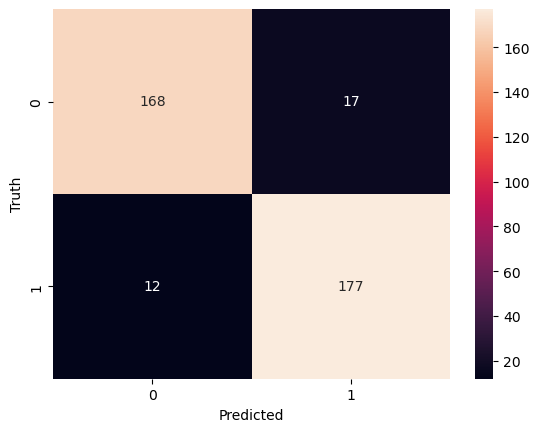

In [36]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [37]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       185
           1       0.91      0.94      0.92       189

    accuracy                           0.92       374
   macro avg       0.92      0.92      0.92       374
weighted avg       0.92      0.92      0.92       374



### Inference

In [38]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 2s 2s/step


array([[0.7058443 ],
       [0.8250638 ],
       [0.7767288 ],
       [0.20449975],
       [0.13888934]], dtype=float32)